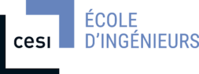

# <center><font size="30">Projet Data</font></center>

### <center>Guillaume PIERDET - Enzo BACHAR - Thibault MAILLARD - Pierre-Louis BAILLET - Lucas HAAS</center>

## Livrables 2 - Modélisation du problème

### ÉTAPE 2 : Génération aléatoire des données

In [8]:
#Import pymongo to connect to database
from pymongo import MongoClient
import pprint, datetime

#Localhost
client = MongoClient('localhost', 27017)

#Get database and vehicules collection
db = client["DataProject"]

In [1]:
#Import pymongo to connect to database
from pymongo import MongoClient
import pprint, datetime

#Localhost
client = MongoClient('localhost', 27017)

#Get database and vehicules collection
db = client["DataProject"]
aretes_collection = db["aretes"]

aretes = aretes_collection.find().limit(5)

for i in aretes:
    print(aretes)

### Algorithme de génération de graphe 1

In [28]:
import random as rd
from time import time

def random_graph(nb_sommets, degres_max, poids_max_aretes):
    degres = [rd.randint(1,degres_max) for _ in range(nb_sommets)]

    sommets_part = []
    sommets_non_parc = [i for i in range(nb_sommets)]

    aretes = []
    sommets = [[] for i in range(nb_sommets)]

    # Initialisation

    a = rd.randrange(nb_sommets)
    b = rd.randrange(nb_sommets)
    while a == b:
        b = rd.randrange(nb_sommets)

    aretes.append([rd.randint(1,poids_max_aretes),[a,b]])
    sommets[a].append(b)
    sommets[b].append(a)

    sommets_part.append(a)
    sommets_non_parc.remove(a)

    if b != a:
        sommets_part.append(b)
        sommets_non_parc.remove(b)

    # Boucle
    while sommets_non_parc != []:
        a = rd.choice(sommets_part)
        b = rd.choice(sommets_non_parc)

        if len(sommets[a]) != degres[a]:

            aretes.append([rd.randint(1,poids_max_aretes),[a,b]])
            sommets[a].append(b)
            sommets[b].append(a)

            sommets_part.append(b)
            sommets_non_parc.remove(b)

        else:
            sommets_part.remove(a)

    while sommets_part != []:
        a = rd.choice(sommets_part)
        b = rd.choice(sommets_part)
        if a == b:
            if len(sommets[a]) >= degres[a]:
                sommets_part.remove(a)
            else:
                aretes.append([rd.randint(1,poids_max_aretes),[a,b]])
                sommets[a].append(b)
                sommets[b].append(a)
        else:
            if len(sommets[a]) >= degres[a]:
                sommets_part.remove(a)

            elif len(sommets[b]) >= degres[b]:
                sommets_part.remove(b)

            else:
                aretes.append([rd.randint(1,poids_max_aretes),[a,b]])
                sommets[a].append(b)
                sommets[b].append(a)

    return [sommets, aretes]

start = time()
graphe = random_graph(10000,6,100)

sommet_db, aretes_db = [] , []
for i in range(len(graphe[0])):
    sommet_db.append({
        "num_sommet": i,
        "voisins": list(graphe[0][i])
    })
for i in range(len(graphe[1])):
    aretes_db.append({
        "num_arete": i,
        "poids": graphe[1][i][0],
        "sommets_adj": list(graphe[1][i][1])
    })

collection_sommets = db["sommets"]
collection_aretes = db["aretes"]
collection_sommets.drop()
collection_aretes.drop()
collection_sommets.insert_many(sommet_db)
collection_aretes.insert_many(aretes_db)

print(time()-start)

1.8991694450378418


### Algorithme de génération de graphe 2

In [21]:
#Import pymongo to connect to database
from pymongo import MongoClient
import pprint, datetime

#Localhost
client = MongoClient('localhost', 27017)

#Get database and vehicules collection
db = client["DataProject"]

# Génération des graphes
import random as rd
from time import time

def random_graph(sommets, poids_min, poids_max, seuil):
    graphe = []
    degreMax = 6
    disconnect = []
    for i in range(sommets):
        disconnect.append(i)
        liste = []
        graphe.append(liste)
    disconnect.remove(0)
    for i in range(sommets):
        if (len(disconnect) != 0):
            poids = rd.randint(poids_min, poids_max)
            graphe[i].append((disconnect[0], poids))
            graphe[disconnect[0]].append((i, poids))
            del disconnect[0]
        for j in range(sommets):
            if(rd.random() > seuil and len(graphe[i]) < degreMax and len(graphe[j]) < degreMax):
                if j in disconnect:
                    disconnect.remove(j)
                poids = rd.randint(poids_min, poids_max)
                graphe[i].append((j,poids))
                graphe[j].append((i,poids))
    return graphe


start = time()
graphe = random_graph(10000, 0, 10, 0.8)

#print(graphe)

# Insertion dans la base
sommets_db, aretes_db = [], []
for i in range(len(graphe)):
    num = 0
    listVoisins = []
    for j in range(len(graphe[i])):
        listVoisins.append(graphe[i][j][0])
        aretes_db.append({
            "num_arete": num,
            "poids": graphe[i][j][1],
            "sommets_adj": [i, graphe[i][j][0]]
        })
        num += 1
    sommets_db.append({
        "num_sommet": i,
        "voisins": listVoisins
    })


collection_sommets = db["sommets"]
collection_aretes = db["aretes"]
collection_sommets.drop()
collection_aretes.drop()
collection_sommets.insert_many(sommets_db)
collection_aretes.insert_many(aretes_db)
stop = time()
print(stop-start)
#pprint.pprint(list(collection_sommets.find()[0:5]))
#pprint.pprint(list(collection_aretes.find()[0:5]))

27.934551239013672


### Algorithme de génération du trafic

In [30]:
def createTraficColl(aretes_collection, heure_debut, heure_fin):
    trafic_list = []
    
    for aretes in aretes_collection.find():
        for i in range((heure_fin-heure_debut)*60):
            if i%5 == 0:
                trafic_list.append({
                    "num_arete": aretes["num_arete"],
                    "heure": heure_debut+i//60,
                    "minutes": i%60,
                    "nb_vehicules": rd.randint(1,10*aretes["poids"])
                })
            
    trafic_collection = db['trafic']
    trafic_collection.drop()
    trafic_collection.insert_many(trafic_list)
    
aretes_collection = db["aretes"]

start = time()
createTraficColl(aretes_collection, 8,17)
print(time()-start)

10.16016936302185


### ÉTAPE 3 : Modélisation du problème

### Périmètre d'étude du problème

#### Reformulation du besoin

On cherche à générer l'itinéraire d'une tournée de livraison, qui relie un réseau de villes, puis revient à son point de départ, en minimisant la durée de la tournée et en prenant compte le trafic prévionnel pour les différentes tranches horaires.

#### Rappel des objectifs de l'étude

L'objectif est de minimiser la durée de la tournée.

#### Contraintes

- Contraintes obligatoires:
 - Revenir au point de départ
 - Passer une fois par chaque ville devant être livrée
 - Prendre en compte le trafic
 - k camions disponibles simultanément pour effectuer les livraisons
 
- Contraintes supplémentaires:
 - Les camions ont chacun une capacité prédéfinie

#### Identification du problème à un problème d'étude connu

Notre problème s'apparente au problème de tournées de véhicules (VRP), qui consiste à determiner un plus court chemin visitant chaque ville une et une seule fois, avant de revenir au point de départ. C'est une classe de problèmes de recherche opérationnelle et d'optimisation combinatoire. Il s'agit de déterminer les tournées d'une flotte de véhicules afin de livrer une liste de clients, ou de réaliser des tournées d'interventions ou de visites.
<br/><br/><br/><hr/>
<i>Contraintes supplémentaires / Variantes :</i>

Le problème d'encombrement des camions peut être associé au problème du sac à dos, modélisant le remplissage d'un sac à dos ne pouvant pas supporter qu'un certain poids. L'ensemble des objets possède un poids et une valeur. Ce problème s'apparente donc au problème du Capactited VRP (CVRP).

Il existe des variantes de ce problème, qui incluent des contraintes supplémentaires, comme le VRP avec fenêtres temporelles (VRPTW pour VRP with Time Windows), le VRP avec livraison/ramassage (VRPPD pour VRP with Pick-up and Deliveries), le VRP avec contraintes de distance et capacité (DCVRP pour VRP with Distance and Capacity constraints)

<br/><br/>
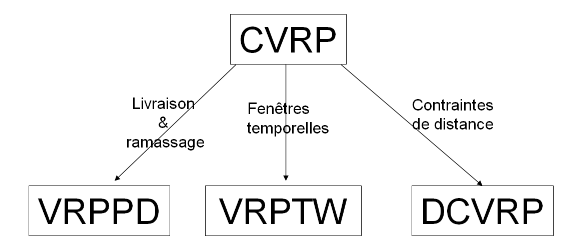

### Définition mathématique du problème

Soit un graphe $ G = (V,E) $, qui est connexe et non orienté.

$x_{ijk}$ égale à $1$ si le véhicule $k$ parcourt l'arc $(v_i, v_j)$, $0$ sinon, sachant que $v_0$ est le sommet de départ.


On a les constantes suivantes:

- $n$: nombre de sommets

- $m$: nombre de véhicules

- $c_{ij}$ le coût de l'arête entre les sommets $i$ et $j$

La fonction objectif du problème d'optimisation est définie telle que :

$$Minimiser \sum \limits _{i=1}^n \sum \limits _{j=1}^n c_{ij} \sum \limits _{k=1}^m x_{ijk}$$

Sujet aux contraintes suivantes:

- La tournée passe au moins une fois par chaque lieu de livraison :
$$ ∀ j \in \mathbb{N} | 1 \leq j \leq n \,\,\,\,\,\,\,\, \sum \limits _{i=1}^n \sum \limits _{k=1}^m x_{ijk} \geq 1 $$
$$ ∀ i \in \mathbb{N} | 1 \leq i \leq n \,\,\,\,\,\,\,\, \sum \limits _{j=1}^n \sum \limits _{k=1}^m x_{ijk} \geq 1 $$

- La tournée revient au point de départ:
$$ ∀ k \in \mathbb{N} | 1\leq k \leq m \,\,\,\,\,\,\,\, \sum \limits _{j=1}^n x_{0jk} \geq 1$$ 
$$ ∀ k \in \mathbb{N} | 1\leq k \leq m \,\,\,\,\,\,\,\, \sum \limits _{i=1}^n x_{i0k} \geq 1 $$ 

**Nous ajouterons certaines contraintes à terme:**
- Contraintes de capacité:
$$ ∀ k \in \mathbb{N} | 1\leq k \leq m \,\,\,\,\,\,\,\, \sum \limits _{i=1}^n \sum \limits _{j=1}^n x_{ijk} \leq Q_k $$



### Etude de la complexité du problème

Le problème du voyageur de commerce est **NP-Complet**, car il est possible de vérifier une solution en temps polynomial et tous les autres problèmes de la classe NP se ramènent à celui-ci via une réduction polynomiale. Il est donc **NP-difficile**. Le problème de tournées de véhicules étant au moins aussi difficile que le problème du voyageur de commerce, il est également **NP-difficile**.

Ce problème d'optimisation n'admet pas encore à ce jour d'algorithme permettant de trouver une solution exacte rapidement dans tous cas. Il est donc nécessaire de parcourir tous les chemins 𝑛 possibles, ce qui revient à une complexité asymptotique de : $𝑂(𝑛!)$

Ainsi, le temps de résolution d'un algorithme de résolution exacte sera trop important. Nous allons donc utiliser un algorithme qui ne nous donnera pas forcement le résultat exact mais une très bonne estimation en temps raisonnable : les méta-heuristiques.

### ÉTAPE 4 : Modélisation algorithmique

Pour répondre aux besoins de ce problème, nous pouvons utiliser plusieurs métaheuristiques. Nous utiliserons l'algorithme génétique pour résoudre ce problème, car c'est le plus utilisé pour la résolution du problème du VRP.
Ces algorithmes s'inspirent de l'évolution naturelle, notamment de la sélection de Darwin, et de la reproduction selon les règles de Mendel. Elle a été introduite en 1975 par Holland, puis formalisée par Goldberg en 1989 pour être appliquée à la résolution de problèmes d'optimisation.

Un algorithme génétique entretient une **population** de solutions au problème à optimiser. La qualité de ces solutions est appelée **individus** et est donnée par une **fonction d'évaluation** $f$. L'algorithme applique des opérateurs génétiques de **croisement** et de **mutation** à la population en vue d'en générer une autre. A partir de deux individus **parents**, l'opérateur de **croisement** génère un ou deux individus **enfants** héritant chacun en partie de la structure de ses **parents**. L'opérateur de **mutation** agit quant à lui sur un seul **individu** en modifiant une partie de sa structure. 
Les opérateurs de **mutation** et de **croisement** correspondent à deux principes de la sélection naturelle des espèces: les meilleurs éléments se reproduisent entre eux et assurent l'amélioration de la **population** en transférant leur information génétique, et parfois, quelques éléments mutent afin de maintenir une diversité génétique au sein de la population.



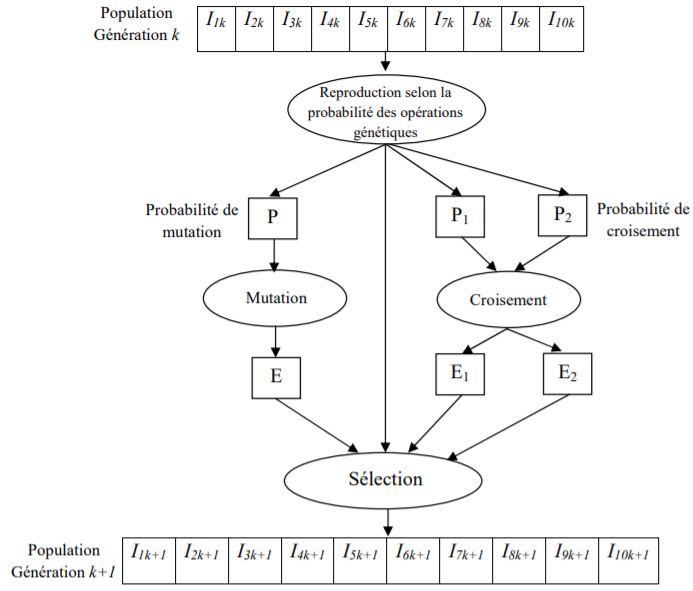


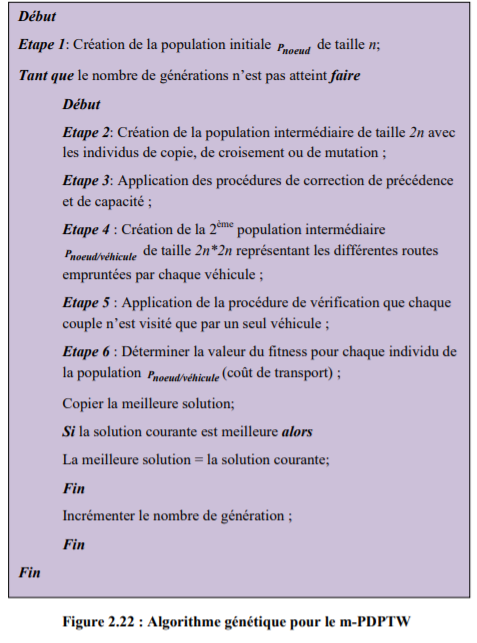






In [3]:
nb_camions = 5
nb_iteration = 100
nb_populations = 5

population = [[[] for i in range(nb_camions)] for i in range(nb_populations)]

#Cette liste sera remplie aléatoirement avec les villes devant être livrées

## Ressources

"Synthèse du problème de routage de véhicules", <i>Collection des rapports de recherche de Télécom Bretagne</i> - Sahbi Ben Ismail, François Legras, Gilles Coppin

"Thèse, Une approche génétique pour la résolution du problème VRPTW dynamique", Université d'Artois - Hayan HOUSROUM

"Thèse, Optimisation heuristique pour la résolution du m-PDPTW statique et dynamique", Ecole Centrale de Lille et Ecole Nationale d'Ingénieurs de Tunis - Imen HARBAOUI DRIDI